# Symmetrization of Wannier Hamiltonian and matrices 

By Xiaoxiong Liu : xxliu@physik.uzh.ch

The real-space Wannier Hamiltonian obtained by Wannier90 code generally does not strictly preserve the corresponding symmetry. The slight loss of symmetry will gap the expected band intersections. Berry curvature and orbital magnetic moment are more sensitive to symmetry than energy eigenvalues. In the following, I give details about the symmetrization of Wannier Hamiltonian and matrices.

In WannierBerri, our built-in symmetrization method can enforce symmetrizing Wannier Hamiltonian (Ham_R) and matrices (AA_R, BB_R, CC_R, SS_R) after reading them.

$\texttt{Ham\_R} = <n0|\hat{H}|mR>$

$\texttt{AA\_R} = <n0|\hat{r}|mR>$

$\texttt{BB\_R} = <n0|\hat{H}\cdot(\hat{r}-\hat{R})|mR>$

$\texttt{CC\_Rc} = i \epsilon_{abc} <n0|\hat{r}_a\cdot\hat{H}\cdot(\hat{r}_b-\hat{R}_b)|mR>$

$\texttt{SS\_R} = <n0|\hat{\sigma}|mR>$

They are needed when calculating different quantities:
1. Energy eigenvalue  <-- Ham_R
2. Berry Curvature  <-- Ham_R, AA_R
3. Orbital magnetic moment  <-- Ham_R, AA_R, BB_R, CC_R
4. Spin magnetic moment  <-- SS_R

NOTE: This method only works with Wannier Hamiltonian without maximal localized. 

We will show you two examples:
1. Symmetrize nonmagnetic system with SOC (trigonal Te)
2. Symmetrize magnetic system with SOC (bcc Fe)

In [1]:
#import necessary packages
import wannierberri as wberri
import warnings
tested_version = '1.3.0'
if wberri.__version__ != tested_version:
    warnings.warn(f'This tutorial was tested with version {tested_version} of wannierberri. You are using version {wberri.__version__}.')



import numpy as np
import matplotlib.pyplot as plt #for plotting figures

try :
    parallel.shutdown()
except:
    parallel = wberri.Parallel(num_cpus=8)


initializing ray with  {'num_cpus': 8}


2025-05-14 16:30:46,658	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


## Nonmagnetic system (trigonal Te)

In [2]:
#Reading Wannier Hamiltonian and position element matrix from Te_tb.dat file.
#We bulit to system, `system_Te` without symmetrization and `system_Te_sym` with symmetrization

import copy

from irrep.spacegroup import SpaceGroup
from wannierberri.symmetry.sawf import SymmetrizerSAWF
from wannierberri.symmetry.projections import Projection


system_Te=wberri.System_tb(tb_file='./Te_data/Te_tb.dat',berry=True)
system_Te.spin_block2interlace()  # the data come from old vasp, which stored WF spins separated into two blocks. QE and modern VASP intrelace the spin channels

#Check unsymmetrized system
system = system_Te

def check_onsite(system):
    #find index of R=[0,0,0] in R-vector list
    #dimension of Hamiltonian is [num_wann, num_wann, num_Rvec]
    iR0 = system.rvec.iR0
    onsite_Te_1 = np.diagonal(system.Ham_R[iR0]).real[:2]
    onsite_Te_2 = np.diagonal(system.Ham_R[iR0]).real[2:4]
    print(f'on-site energy of Te_1 orbitals spin up : {onsite_Te_1[0]}, spin_down: {onsite_Te_1[1]}, difference: {abs(onsite_Te_1[0]-onsite_Te_1[1])}')
    print(f'on-site energy of Te_2 orbitals spin up : {onsite_Te_2[0]}, spin_down: {onsite_Te_2[1]}, difference: {abs(onsite_Te_2[0]-onsite_Te_2[1])}')
    print('difference:', abs(onsite_Te_1-onsite_Te_2))

print('unsymmetrized')
check_onsite(system_Te)


reading TB file ./Te_data/Te_tb.dat ( written on  9May2022 at 22:54:49 )
Real-space lattice:
 [[ 4.457      0.         0.       ]
 [-2.2285     3.8598752  0.       ]
 [ 0.         0.         5.9581176]]
Number of wannier functions: 24
Number of R points: 195
Recommended size of FFT grid [7 9 5]
Reading the system from ./Te_data/Te_tb.dat finished successfully
unsymmetrized
on-site energy of Te_1 orbitals spin up : -5.585966, spin_down: -5.5859776, difference: 1.1599999999667432e-05
on-site energy of Te_2 orbitals spin up : -5.588091, spin_down: -5.5880802, difference: 1.0800000000088517e-05
difference: [0.002125  0.0021026]


In [3]:


system_Te_sym_new=wberri.System_tb(tb_file='./Te_data/Te_tb.dat',berry=True)
system_Te_sym_new.spin_block2interlace()  # the data come from old vasp, which stored WF spins separated into two blocks. QE and modern VASP intrelace the spin channels


# #symmetrization step - new method using SymmetrizerSAWF 
x = 0.274
positions = np.array([ [x , x  ,   0.],
                      [1-x, 0  , 1./3],
                      [0  , 1-x, 2./3]] )
        
spacegroup = SpaceGroup(cell=(system_Te.real_lattice, positions, [1,1,1]),
                                     magmom=None, include_TR=True,
                                     spinor=True)
spacegroup.show()

proj_list = []
for proj_str in ["s","p"]:
        proj = Projection(position_num=positions, orbital=proj_str, spacegroup=spacegroup)
        # print (f"adding projection {proj} ({pos} {suborbital})")
        proj_list.append(proj)
symmetrizer = SymmetrizerSAWF().set_spacegroup(spacegroup).set_D_wann_from_projections(projections=proj_list)
system_Te_sym_new.symmetrize2(symmetrizer)


print('symmetrized')
check_onsite(system_Te_sym_new)



reading TB file ./Te_data/Te_tb.dat ( written on  9May2022 at 22:54:49 )
Real-space lattice:
 [[ 4.457      0.         0.       ]
 [-2.2285     3.8598752  0.       ]
 [ 0.         0.         5.9581176]]
Number of wannier functions: 24
Number of R points: 195
Recommended size of FFT grid [7 9 5]
Reading the system from ./Te_data/Te_tb.dat finished successfully


 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       
a0 =  4.4570   0.0000   0.0000  
a1 = -2.2285   3.8599   0.0000  
a2 =  0.0000   0.0000   5.9581  



 ---------- SPACE GROUP ----------- 


Space group: P3_1211' (# 152.34)
Number of symmetries: 12 (mod. lattice translations)

 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

spinor rot.         : | 1.000+0.000j  0.000+0.000j |
                      | 0.000+0.000j  1.000+0.000j |

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [0. 0. 1.] ; angle =  0 ,

In [5]:

#Symmetrization step (old method interface, but still works so far. Internally it creates a SymmetrizerSAWF object)
system_Te_sym_old=copy.deepcopy(system_Te)
system_Te_sym_old.symmetrize(
    # positions: positions of each atoms in a unitcell (direct coordinate system)
    positions = positions,
    # atom_name: name of each atoms, need to correspond to position order.
    atom_name = ['Te','Te','Te'],
    # projections: should be the same with projection card in wannier90.win
    proj = ['Te:s','Te:p'],
    # soc: with soc or spinless
    soc=True,
    )

print('symmetrized - old interface')
check_onsite(system_Te_sym_old)



 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       
a0 =  4.4570   0.0000   0.0000  
a1 = -2.2285   3.8599   0.0000  
a2 =  0.0000   0.0000   5.9581  



 ---------- SPACE GROUP ----------- 


Space group: P3_1211' (# 152.34)
Number of symmetries: 12 (mod. lattice translations)

 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

spinor rot.         : | 1.000+0.000j  0.000+0.000j |
                      | 0.000+0.000j  1.000+0.000j |

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [0. 0. 1.] ; angle =  0 , inversion : False, time reversal: False

 ### 2 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [-kx, -ky, -kz]

spinor rot.         : | 1.000+0.000j  0.000+0.000j |
                      | 0.000+0.000j  1.000+0.000j |

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [0. 0. 1.] ; angle =  0 , inversion : F

Output card `Wannier atoms info` is showing informations about orbitals.

Line `(1, 'Te', array([0.274, 0.274, 0.   ]), ['s', 'p'], [[0, 12], [3, 4, 5, 15, 16, 17]])` read as:
First atoms is Te at position 0.274, 0.274, 0. It contribute orbital $s$ and $p$. Index of s-orbitals are 0 and 12. Index of d-orbitals are 3, 4, 5, 15, 16, 17.

Informations of space group are showed as well.

We can check if real space Hamiltonian are symmetrized.

In [4]:
#We check symmetry with operator 1 from Space group informations in the output.
#prepare operator
symop = spacegroup.symmetries[2]
rot = symop.rotation
trans = symop.translation
print (f"rotation \n {rot}\n translation :{trans}")

print (f"positions before operation: \n {positions}")
positions_rot =  positions @ rot.T + trans[None,:]
print('After operation\n', positions_rot)

print (f"they match the original positions upto reordering and integer latticle vector : \n{positions_rot[[2,0,1]]-positions}")


rotation 
 [[ 0 -1  0]
 [ 1 -1  0]
 [ 0  0  1]]
 translation :[0.         0.         0.33333333]
positions before operation: 
 [[0.274      0.274      0.        ]
 [0.726      0.         0.33333333]
 [0.         0.726      0.66666667]]
After operation
 [[-0.274       0.          0.33333333]
 [ 0.          0.726       0.66666667]
 [-0.726      -0.726       1.        ]]
they match the original positions upto reordering and integer latticle vector : 
[[-1. -1.  1.]
 [-1.  0.  0.]
 [ 0.  0.  0.]]


Checking band structures in k-space.

The Brillouin zone of trigonal Te is:
<img src="./Te_data/Te_BZ.png" width="300">
We only consider kz=$\pi$ plane. 
<img src="./Te_data/Te_kz=pi.png" width="300">
The band structures of the three path:

L1 -> H -> A1

L2 -> H -> A2

L3 -> H -> A3

should be the same because of C3 rotation symmetry.

But the Wannier Hamitonian break the symmetries slightly. So the band structure of the three path may not the same.

After symmetrization they are the same.


In [5]:
#generate k-path
path=wberri.Path(system_Te,
    #start and end points of k_path.
    #If two paths are not consencutive, put `None` between them. 
    nodes=[[0,0.5,0.5],[1./3,1./3,0.5],[1.,0.,0.5],None, 
            [0.5,0.,0.5],[1./3,1./3,0.5],[0.,1.,0.5],None,
            [0.5,0.5,0.5],[1./3,1./3,0.5],[0.,0.,0.5]],
    labels=["L1","H","A1","L3","H","A3","L2","H","A2"],
    #length: proportional to number of kpoints.
    length=1000) 


bands_Te = wberri.evaluate_k_path(path = path, parallel=parallel, system = system_Te)
bands_Te_sym = wberri.evaluate_k_path(path = path, parallel=parallel, system = system_Te_sym_new)



Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x794cd45db9b0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x794d886c7b30> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x794cd45db9b0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 676 points and labels {0: 'L1', 75: 'H', 225: 'L3', 300: 'H', 450: 'L2', 525: 'H', 675: 'A2'}
generating K_list
Done 
Done, sum of weights:67

/home/stepan/github/wannier-berri/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    676 K-points on   8 processes:     1.1211 ; per K-point          0.0017 ; proc-sec per K-point          0.0133
time1 =  0.016185998916625977
Totally processed 676 K-points 
run() finished
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x794d706511f0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x794d705a9a60> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x794d706511f0>
All calculators are compatible
Symmetrization switc

In [6]:
#read energy eigenvalue data of band 18 and 19 from results.
band_Te_01 = bands_Te.get_data(quantity='Energy',iband=(0,1))
band_Te_sym_01 = bands_Te_sym.get_data(quantity='Energy',iband=(0,1))
#read k-path data
band_k=path.getKline()

Text(0.5, 0, 'L -> H -> A')

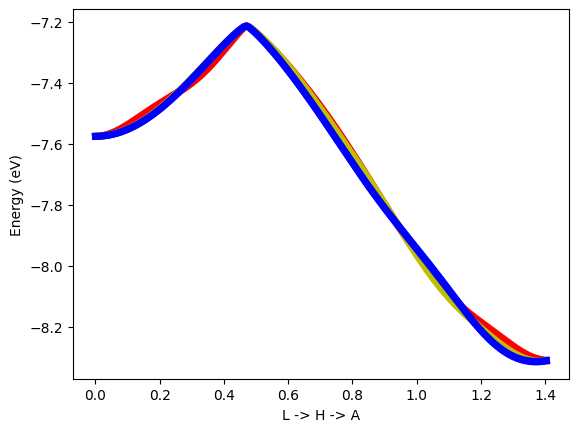

In [7]:
#plot band structure with unsymmetrized system
%matplotlib inline
NK=len(band_k)
colour = ['r','y','b']
NK_one = NK//3
plt.figure()
for i in range(3):
    plt.plot(band_k[0:NK_one],band_Te_01[NK_one*i:NK_one*(i+1)],colour[i],linewidth=5)
plt.ylabel('Energy (eV)')
plt.xlabel('L -> H -> A')

Text(0.5, 0, 'L -> H -> A')

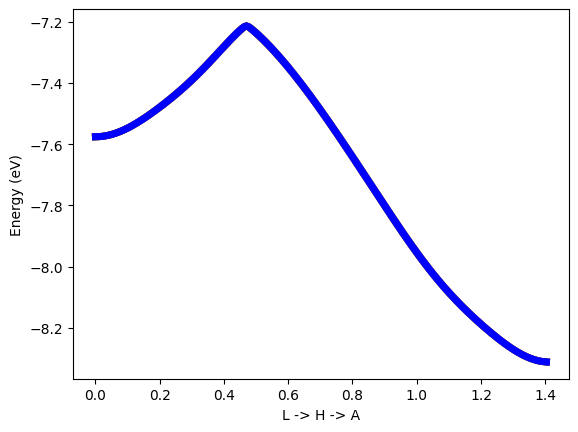

In [8]:
#plot band structure with symmetrized system
plt.figure()
for i in range(3):
    plt.plot(band_k[0:NK_one],band_Te_sym_01[NK_one*i:NK_one*(i+1)],colour[i],linewidth=5)
plt.ylabel('Energy (eV)')
plt.xlabel('L -> H -> A')

Symmetrization fix the symmetries of Hamiltonian

The Berry curvature is more sensitive to symmetry than energy eigenvalues.

In [9]:
# calculate Berry curvature alone a k-path.
path_berry=wberri.Path(system_Te,
                 nodes=[[0,0.5,0.5],[1./3,1./3,0.5],[1./3,1./3,0.]],
                 labels=["L","H","K",],
                 length=500)

quantities = {"Energy":wberri.calculators.tabulate.Energy(),
              "berry":wberri.calculators.tabulate.BerryCurvature(),}

calculators={}
calculators ["tabulate"] = wberri.calculators.TabulatorAll(quantities,ibands=[18,19],mode="path")

berry_Te = wberri.evaluate_k_path(system=system_Te,
        path=path_berry,
        parallel=parallel,
        quantities=["berry_curvature"] )

berry_Te_sym = wberri.evaluate_k_path(system=system_Te_sym_new,
        path=path_berry,
        parallel=parallel,
        quantities=["berry_curvature"] )


Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x794cc7e18380>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "berry_curvature" : <wannierberri.calculators.tabulate.BerryCurvature object at 0x794cb63083e0> : calculator not described

 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x794cc7e18a70> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x794cc7e18380>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 80 points and la

/home/stepan/github/wannier-berri/wannierberri/result/tabresult.py:342: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


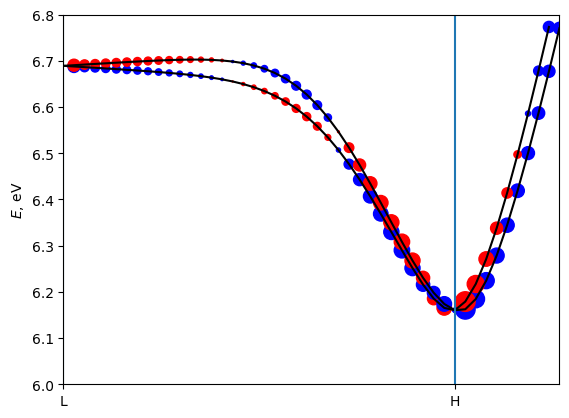

In [12]:
# use built-in plotting method to plot berry cuvature.
# red means positive, blue means negative.
# size of the dots shows the amplitude of the quantity.
# unsymmetrized:
import matplotlib
# matplotlib.use('TkAgg')

berry_Te.plot_path_fat(path_berry,
              quantity='berry_curvature',
              component='z', # only take z compoment
              Emin=6.0,  Emax=6.8,
              mode="fatband",
              fatfactor=20,  # size of dots.
              close_fig=False,
              )
plt.show()
plt.close()

/home/stepan/github/wannier-berri/wannierberri/result/tabresult.py:342: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


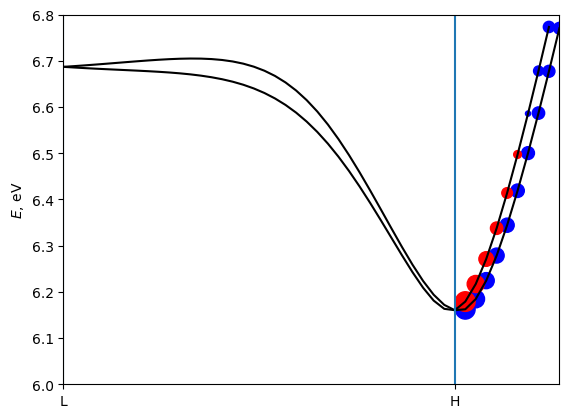

In [13]:
# symmetrized: 
berry_Te_sym.plot_path_fat(path_berry,
              quantity='berry_curvature',
              component='z', # only take z compoment
              Emin=6.0,  Emax=6.8,
              mode="fatband",
              fatfactor=20,  # size of dots.
              close_fig=False,
              )
plt.show()
plt.close()

z-component of Berry curvature alone L-H path should be zero because of symmetry. The loss of symmetry has a big impact to Berry curvature of single k-point. It is fixed by symmetrization.

## Magnetic system with SOC (bcc Fe)

bcc Fe is a magnetic system with magnetic moment -2.31 \mu_B point to -z direction of cartesian coordinate system of lattice. We need to set parameter 'magmom'.

In [16]:
system_Fe=wberri.System_tb(tb_file='./Fe_data/Fe_tb.dat',berry=True)
system_Fe_sym_new=copy.deepcopy(system_Fe)
spacegroup = SpaceGroup(cell=(system_Fe.real_lattice, [[0,0,0]], [1]), magmom=[[0,0,1]], include_TR=True, spinor=True)

proj_sp3d2 = Projection(position_num=[[0,0,0]], orbital="sp3d2", spacegroup=spacegroup)
proj_t2g = Projection(position_num=[[0,0,0]], orbital="t2g", spacegroup=spacegroup)

symmetrizer = SymmetrizerSAWF().set_spacegroup(spacegroup).set_D_wann_from_projections(projections=[proj_sp3d2, proj_t2g])
system_Fe_sym_new.symmetrize2(symmetrizer)



reading TB file ./Fe_data/Fe_tb.dat ( written on 13May2022 at 01:23:14 )
Real-space lattice:
 [[ 1.4349963  1.4349963  1.4349963]
 [-1.4349963  1.4349963  1.4349963]
 [-1.4349963 -1.4349963  1.4349963]]
Number of wannier functions: 18
Number of R points: 27
Recommended size of FFT grid [5 5 5]
Reading the system from ./Fe_data/Fe_tb.dat finished successfully
orbitals = ['sp3d2']
orbitals = ['t2g']
calculating Wannier functions for sp3d2 at [[0 0 0]]
calculating Wannier functions for t2g at [[0 0 0]]
len(D_wann_list) = 2
D.shape [(0, 16, 12, 12), (0, 16, 6, 6)]
num_wann 18
D_wann_block_indices [[ 0 12]
 [12 18]]


In [18]:

system_Fe_sym_old=copy.deepcopy(system_Fe)
system_Fe_sym_old.symmetrize(
             proj = ['Fe:sp3d2;t2g'],
             atom_name = ['Fe'],
             positions = [[0,0,0]],
             #magmom: magnetic moment of each atoms.
             magmom = [[0.,0.,-2]],
             soc=True,
             )




 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       
a0 =  1.4350   1.4350   1.4350  
a1 = -1.4350   1.4350   1.4350  
a2 = -1.4350  -1.4350   1.4350  



 ---------- SPACE GROUP ----------- 


Space group: I4/mm'm' (# 139.537)
Number of symmetries: 16 (mod. lattice translations)

 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

spinor rot.         : | 1.000+0.000j  0.000+0.000j |
                      | 0.000+0.000j  1.000+0.000j |

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [ 0.040875 -0.315963  0.94789 ] ; angle =  0 , inversion : False, time reversal: False

 ### 2 

rotation : | -1   0   0 |
           |  0  -1   0 |
           |  0   0  -1 |


 gk = [-kx, -ky, -kz]

spinor rot.         : | 1.000+0.000j  0.000+0.000j |
                      | 0.000+0.000j  1.000+0.000j |

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [-0.040875 -0.315

/home/stepan/github/wannier-berri/wannierberri/system/system_R.py:378: UserWarning: for effeciency of symmetrization, it is recommended to give orbitals separately, not combined by a ';' sign.But you need to do it consistently in wannier90 
  warnings.warn("for effeciency of symmetrization, it is recommended to give orbitals separately, not combined by a ';' sign."


[(0, 16, 18, 18)]
num_wann 18
D_wann_block_indices [[ 0 18]]


Important explanations:
1. The projection card in wannier90.win of bcc Fe is `'Fe':sp3d2;dxz,dyz,dxy`. But in the symmetrization, orbitals must project to complete sets of coordinates after symmetry opration. So we must label orbitals which shares the same complete sets of coordinates. eg: `sp3d2, dxz,dyz,dxy -> sp3d2, t2g` and `sp,px,py -> sp,p2`
2. We print out all the symmetry operators in the space group. But magnetic moments break some of them. Afte line `Symmetrizing start`. You can find details about which operator belong to the magnetic group.

bcc Fe have inversion symmetry, so the Berry curvature dipole should be zero. Ref: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.115.216806

In [21]:
system_Fe_sym = system_Fe_sym_new
#calculate berry curvature dipole
Efermi_Fe = np.linspace(15.5,16,301)
NK = 10

grid = wberri.Grid(system_Fe,NK=NK,NKFFT=1)

result_Fe = wberri.run(system=system_Fe,
            grid=grid,
            calculators = {"BerryDipole":wberri.calculators.static.BerryDipole_FermiSea(Efermi=Efermi_Fe,tetra=True)},
            adpt_num_iter=0,
            fout_name='Fe',
            restart=False,
            print_Kpoints=False                       
            )

result_Fe_sym = wberri.run(system=system_Fe_sym,
            grid=grid,
            calculators = {"BerryDipole":wberri.calculators.static.BerryDipole_FermiSea(Efermi=Efermi_Fe,tetra=True)},
            adpt_num_iter=0,
            fout_name='Fe_sym',
            restart=False,
            print_Kpoints=False
            )

Starting run()
Using the follwing calculators : 
############################################################

 'BerryDipole'  :  <wannierberri.calculators.static.BerryDipole_FermiSea object at 0x794bec54f290>  : Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`
############################################################
Calculation on  grid - checking calculators for compatibility
BerryDipole <wannierberri.calculators.static.BerryDipole_FermiSea object at 0x794bec54f290>
All calculators are compatible
Grid is regular
The set of k points is a Grid() with NKdiv=[10 10 10], NKFFT=[1 1 1], NKtot=[10 10 10]
generating K_list
Done in 0.0019609928131103516 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.009967565536499023 s 
K_list contains 1000 Irreducible points(100.0%) out of initial 10x1

In [22]:
#read data

Fe_BCD = result_Fe.results["BerryDipole"].data 
Fe_sym_BCD = result_Fe_sym.results["BerryDipole"].data

Text(0, 0.5, 'Berry curvature dipole')

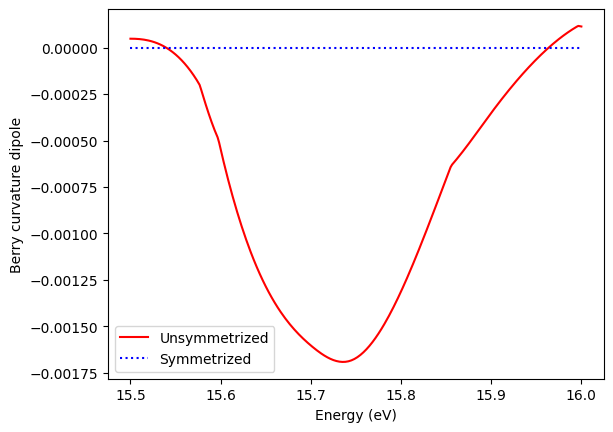

In [23]:
#unsymmetrized
#print zz component of berry dipole
# %matplotlib inline
plt.plot(Efermi_Fe,Fe_BCD[:,2,2],'r',label="Unsymmetrized") 
plt.plot(Efermi_Fe,Fe_sym_BCD[:,2,2],'b:',label="Symmetrized") 
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('Berry curvature dipole')


Symmetrized system gives us better results with low-density k-grid. But it still looks like not perfect zero. At some energy where have band intersections, we can see some little peaks come from digital error. There are very large Berry curvature and it's divergent around band intersections. They may enlarge digital errors. 